In [2]:
import polars as pl
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("Clustered.txt", skiprows=1,
                         names=["Transition Energy (eV)", "Transition Amplitude (a.u.)", "Transition Width (eV)",
                                "TDM_x", "TDM_y", "TDM_z", "TDM Theta (degrees)", "Transition Symmetry",
                                "TDM_xx", "TDM_yy", "TDM_zz", "TDM_xy", "TDM_xz", "TDM_yz", "Originating atom",
                                "Originating MO", "Cluster"])

df = pl.from_dataframe(df)
print(df)
print(len(df))

shape: (13, 17)
┌────────────┬────────────┬────────────┬───────────┬───┬────────┬────────────┬───────────┬─────────┐
│ Transition ┆ Transition ┆ Transition ┆ TDM_x     ┆ … ┆ TDM_yz ┆ Originatin ┆ Originati ┆ Cluster │
│ Energy     ┆ Amplitude  ┆ Width (eV) ┆ ---       ┆   ┆ ---    ┆ g atom     ┆ ng MO     ┆ ---     │
│ (eV)       ┆ (a.u.)     ┆ ---        ┆ f64       ┆   ┆ i64    ┆ ---        ┆ ---       ┆ f64     │
│ ---        ┆ ---        ┆ f64        ┆           ┆   ┆        ┆ i64        ┆ i64       ┆         │
│ f64        ┆ f64        ┆            ┆           ┆   ┆        ┆            ┆           ┆         │
╞════════════╪════════════╪════════════╪═══════════╪═══╪════════╪════════════╪═══════════╪═════════╡
│ 283.80191  ┆ 0.017448   ┆ 0.236435   ┆ 0.039977  ┆ … ┆ 0      ┆ 1          ┆ 117       ┆ null    │
│ 284.68234  ┆ 0.048513   ┆ 0.223871   ┆ 0.022457  ┆ … ┆ 0      ┆ 2          ┆ 119       ┆ null    │
│ 285.20261  ┆ 0.014443   ┆ 0.225601   ┆ 0.030391  ┆ … ┆ 0      ┆ 1        

Optimal parameters: [0.00611105 0.01      ]


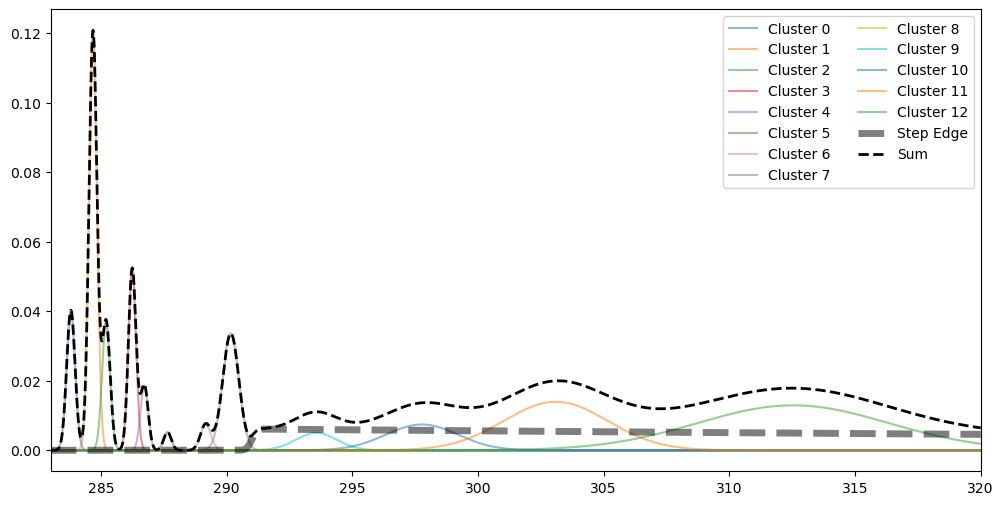

In [12]:
import periodictable as pt
import periodictable.xsf as xsf


def sim_ma(tensor, position, width, theta, phi):
    en = np.linspace(275, 340, 100000)
    e = np.array(
        [np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)]
    )

    # Use einsum to calculate the matrix element
    ma = e.T @ tensor @ e

    peak = 1 / width * np.exp(-(((en - position) / width) ** 2))
    return peak * ma, en


def sim_ma_cluster(df, cluster, theta=0, phi=0):
    # Extract the tensor and convert into a diagonal matrix
    tensor = np.diag(df[cluster, ["TDM_xx", "TDM_yy", "TDM_zz"]].to_numpy()[0])
    position = df[cluster, "Transition Energy (eV)"]
    width = df[cluster, "Transition Width (eV)"]
    theta = np.radians(theta)

    ma, en = sim_ma(tensor, position, width, theta, phi)
    return ma, en

def step(loc: float, width: float, anchor_en: list, anchor: list):
    from scipy.special import erf
    from scipy.optimize import curve_fit

    def step_edge(e, h, d):
        w = width * 2*np.sqrt(2*np.log(2))
        p = loc
        ip = h*(1/2 + 1/2*erf((e-p)/w))
        decay = np.exp(-d*(e-p-w))
        return np.concatenate((ip[e <= p + w], ip[e > p + w]*decay[e > p + w]))

    popt, pcov = curve_fit(step_edge, anchor_en, anchor, p0=[np.max(anchor), 0.01], bounds=([np.min(anchor), .01], [np.max(anchor), .5]))
    print("Optimal parameters:", popt)
    en = np.linspace(275, 340, 100000)
    return step_edge(en, *popt), en

def combine_ma(df, theta = 0, phi = 0):
    ma = []
    for cluser in range(len(df)):
        ma_, en = sim_ma_cluster(df, cluser, theta, phi)
        ma.append(ma_)

    anchor = []
    anchor_en = []
    for i in range(len(ma)):
        max_int = np.max(ma[i][en > 291])
        anchor.append(max_int)
        anchor_en.append(en[np.where(ma[i] == max_int)[0][0]])
    step_edge, en = step(291, 0.1, anchor_en, anchor)
    ma.append(step_edge)
    return ma, en

import matplotlib.pyplot as plt
ma, en = combine_ma(df,theta=0, phi=0)

for i in range(len(ma)):
    if i == len(ma) - 1:
        plt.plot(en, ma[i], label="Step Edge", alpha=0.5, color="black", linestyle="--", linewidth=5)
    else:
        plt.plot(en, ma[i], label=f"Cluster {i}", alpha=0.5)

plt.plot(en, np.sum(ma, axis=0), label="Sum", color="black", linestyle="--", linewidth=2)
plt.legend(ncols = 2)
plt.xlim(283, 320)
# Set figsize
plt.gcf().set_size_inches(12, 6)

In [6]:
import matplotlib.pyplot as plt
import ipywidgets as widgets

@widgets.interact(theta = (0, 90, 1), phi = (0, 360, 1))
def plot_ma(theta = 0, phi = 0):
    ma, en = combine_ma(df, theta, phi)
    plt.plot(en, np.sum(ma, axis=0))
    plt.xlim(283, 320)

interactive(children=(IntSlider(value=0, description='theta', max=90), IntSlider(value=0, description='phi', m…